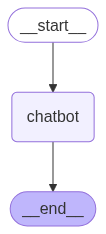

OpenAI工具调用 + LangGraph
支持的功能：
- 查询当前时间：'现在几点了？'
- 查询天气：'北京天气如何？'
- 退出：输入 'exit'
--------------------------------------------------
处理消息: [{'role': 'human', 'content': '现在几点了'}]
------------------------------------------------------------

第1轮大模型输出信息：ChatCompletion(id='chatcmpl-763', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='好的，请把需要转换的文章内容发给我，我会帮你把人物名称改写为昵称并压缩成140字以内的推文。', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning='We need to respond: The user asked: "请使用中文帮我把下面这段文章转换为一条推文，请把文章中的人物名称改写为昵称，长度控制在140字以内："\n\nThey intend to ask: convert following article into a tweet, rename names to nicknames, length <= 140 Chinese characters, and presumably in Chinese. We need to wait for the article. The user didn\'t provide article yet. So we should request it. Also check policy about transformation content? It\'s allowed: we can transform article content into a tweet. It\'s not 

In [1]:


from openai import OpenAI
from datetime import datetime
import json
import os
import random

# LangGraph相关导入
try:
    from typing import Annotated
except ImportError:
    from typing_extensions import Annotated

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# 设置环境变量，确保不走代理
os.environ['HTTP_PROXY'] = ''
os.environ['HTTPS_PROXY'] = ''
os.environ['http_proxy'] = ''
os.environ['https_proxy'] = ''
os.environ['NO_PROXY'] = '*'

# 导入配置
model_configs = {
    "base_url": "http://192.168.10.60:11434/v1/",
    "model_name": 'gpt-oss:20b',
    "api_key": "289751f29159b7d25dadc86c858fa48405bba6740acb57154b00494c0308ed95"
}

# 创建OpenAI客户端
client = OpenAI(
    base_url=model_configs["base_url"],
    api_key=model_configs["api_key"],
)

# 定义工具列表，模型在选择使用哪个工具时会参考工具的name和description
tools = [
    # 工具1 获取当前时刻的时间
    {
        "type": "function",
        "function": {
            "name": "get_current_time",
            "description": "当你想知道现在的时间时非常有用。",
            # 因为获取当前时间无需输入参数，因此parameters为空字典
            "parameters": {},
        },
    },
    # 工具2 获取指定城市的天气
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "当你想查询指定城市的天气时非常有用。",
            "parameters": {
                "type": "object",
                "properties": {
                    # 查询天气时需要提供位置，因此参数设置为location
                    "location": {
                        "type": "string",
                        "description": "城市或县区，比如北京市、杭州市、余杭区等。",
                    }
                },
                "required": ["location"],
            },
        },
    },
]

# 模拟天气查询工具。返回结果示例："北京今天是雨天。"
def get_current_weather(arguments):
    # 定义备选的天气条件列表
    weather_conditions = ["晴天", "多云", "雨天"]
    # 随机选择一个天气条件
    random_weather = random.choice(weather_conditions)
    # 从 JSON 中提取位置信息
    location = arguments["location"]
    # 返回格式化的天气信息
    return f"{location}今天是{random_weather}。"

# 查询当前时间的工具。返回结果示例："当前时间：2024-04-15 17:15:18。"
def get_current_time():
    # 获取当前日期和时间
    current_datetime = datetime.now()
    # 格式化当前日期和时间
    formatted_time = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
    # 返回格式化后的当前时间
    return f"当前时间：{formatted_time}。"

# 封装模型响应函数
def get_response(messages):
    completion = client.chat.completions.create(
        model=model_configs['model_name'],
        messages=messages,
        tools=tools,
    )
    return completion

# LangGraph状态定义
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 将原有的call_with_messages逻辑包装成LangGraph节点
def chatbot_node(state: State):
    """将原有的工具调用逻辑包装成LangGraph节点"""
    try:
        # 获取用户消息
        messages = []
        for msg in state["messages"]:
            if isinstance(msg, dict):
                messages.append(msg)
            else:
                # 处理LangChain消息对象
                messages.append({
                    "role": msg.type if hasattr(msg, 'type') else "user",
                    "content": msg.content if hasattr(msg, 'content') else str(msg)
                })
        
        print(f"处理消息: {messages}")
        print("-" * 60)
        
        # 模型的第一轮调用
        i = 1
        first_response = get_response(messages)
        assistant_output = first_response.choices[0].message
        print(f"\n第{i}轮大模型输出信息：{first_response}\n")
        
        if assistant_output.content is None:
            assistant_output.content = ""
        
        # 将assistant消息添加到消息历史
        assistant_msg = {
            "role": "assistant",
            "content": assistant_output.content
        }
        if assistant_output.tool_calls:
            assistant_msg["tool_calls"] = assistant_output.tool_calls
        messages.append(assistant_msg)
        
        # 如果不需要调用工具，则直接返回最终答案
        if assistant_output.tool_calls == None:
            print(f"无需调用工具，我可以直接回复：{assistant_output.content}")
            return {'messages': [{"role": "assistant", "content": assistant_output.content}]}
        
        # 如果需要调用工具，则进行模型的多轮调用，直到模型判断无需调用工具
        while assistant_output.tool_calls != None:
            # 如果判断需要调用查询天气工具，则运行查询天气工具
            tool_info = {
                "content": "",
                "role": "tool",
                "tool_call_id": assistant_output.tool_calls[0].id,
            }
            if assistant_output.tool_calls[0].function.name == "get_current_weather":
                # 提取位置参数信息
                argumens = json.loads(assistant_output.tool_calls[0].function.arguments)
                tool_info["content"] = get_current_weather(argumens)
            # 如果判断需要调用查询时间工具，则运行查询时间工具
            elif assistant_output.tool_calls[0].function.name == "get_current_time":
                tool_info["content"] = get_current_time()
            
            tool_output = tool_info["content"]
            print(f"工具输出信息：{tool_output}\n")
            print("-" * 60)
            messages.append(tool_info)
            
            assistant_output = get_response(messages).choices[0].message
            if assistant_output.content is None:
                assistant_output.content = ""
            
            # 添加assistant回复到消息历史
            assistant_msg = {
                "role": "assistant",
                "content": assistant_output.content
            }
            if assistant_output.tool_calls:
                assistant_msg["tool_calls"] = assistant_output.tool_calls
            messages.append(assistant_msg)
            
            i += 1
            print(f"第{i}轮大模型输出信息：{assistant_output}\n")
        
        print(f"最终答案：{assistant_output.content}")
        return {'messages': [{"role": "assistant", "content": assistant_output.content}]}
        
    except Exception as e:
        error_msg = f"发生错误：{str(e)}"
        print(error_msg)
        return {'messages': [{"role": "assistant", "content": error_msg}]}

# 创建LangGraph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

# 5.显示可视化图形（可选）
try:
    # 尝试在IPython环境中显示图形
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except ImportError:
    print("IPython not available, skipping graph visualization")
except Exception as e:
    print(f"Graph visualization failed: {e}")
    print("You can view the graph structure by printing the graph object:")
    print(graph)

if __name__ == "__main__":
    print("OpenAI工具调用 + LangGraph")
    print("=" * 50)
    print("支持的功能：")
    print("- 查询当前时间：'现在几点了？'")
    print("- 查询天气：'北京天气如何？'")
    print("- 退出：输入 'exit'")
    print("-" * 50)
    
    while True:
        try:
            user_input = input("\n请输入：")
            if user_input.lower() == 'exit':
                print("再见！")
                break
            
            # 使用LangGraph处理消息
            result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
            
        except KeyboardInterrupt:
            print("\n再见！")
            break
        except Exception as e:
            print(f"发生错误：{e}")
            break